# Inspect the single-lineage model run on the prostate data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from speclet.analysis.arviz_analysis import extract_coords_param_names
from speclet.bayesian_models.lineage_hierarchical_nb import LineageHierNegBinomModel
from speclet.data_processing.common import head_tail
from speclet.io import modeling_data_dir, models_dir
from speclet.managers.data_managers import CrisprScreenDataManager
from speclet.plot import set_speclet_theme

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"

## Data

### Load posterior summary

In [5]:
prostate_post_summary = pd.read_csv(
    models_dir() / "hnb-single-lineage-prostate_PYMC_NUMPYRO" / "posterior-summary.csv"
).assign(var_name=lambda d: [x.split("[")[0] for x in d["parameter"]])
prostate_post_summary.head()

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  \
0  d[AAAAAAATCCAGCAATGCAG]  0.150  0.149    -0.086      0.386      0.002   
1  d[AAAAAACCCGTAGATAGCCT]  0.093  0.159    -0.148      0.355      0.003   
2  d[AAAAAAGAAGAAAAAACCAG] -0.660  0.165    -0.941     -0.410      0.002   
3  d[AAAAAAGCTCAAGAAGGAGG] -0.215  0.154    -0.450      0.042      0.002   
4  d[AAAAAAGGCTGTAAAAGCGT] -0.018  0.134    -0.233      0.192      0.002   

   mcse_sd  ess_bulk  ess_tail  r_hat var_name  
0    0.002    4083.0    2885.0    1.0        d  
1    0.002    3517.0    3221.0    1.0        d  
2    0.002    4850.0    2734.0    1.0        d  
3    0.002    3930.0    3270.0    1.0        d  
4    0.002    5989.0    2999.0    1.0        d

### Load trace object

In [6]:
trace_file = (
    models_dir() / "hnb-single-lineage-prostate_PYMC_NUMPYRO" / "posterior.netcdf"
)
assert trace_file.exists()
trace = az.from_netcdf(trace_file)

### Prostate data

In [7]:
def _broad_only(df: pd.DataFrame) -> pd.DataFrame:
    return df[df["screen"] == "broad"].reset_index(drop=True)


prostate_dm = CrisprScreenDataManager(
    modeling_data_dir() / "lineage-modeling-data" / "depmap-modeling-data_prostate.csv",
    transformations=[_broad_only],
)

In [8]:
prostate_data = prostate_dm.get_data(read_kwargs={"low_memory": False})
prostate_data.head()

sgrna                 replicate_id       lfc p_dna_batch  \
0  AAAGCCCAGGAGTATGGGAG  Vcap-304Cas9_RepA_p4_batch3  0.246450           3   
1  AAATCAGAGAAACCTGAACG  Vcap-304Cas9_RepA_p4_batch3  0.626518           3   
2  AACGTCTTTGAAGAAAGCTG  Vcap-304Cas9_RepA_p4_batch3  0.165114           3   
3  AACGTCTTTGAAGGAAGCTG  Vcap-304Cas9_RepA_p4_batch3 -0.094688           3   
4  AAGAGGTTCCAGACTACTTA  Vcap-304Cas9_RepA_p4_batch3  0.294496           3   

   genome_alignment hugo_symbol screen  multiple_hits_on_gene  \
0  chr2_130522105_-       CFC1B  broad                   True   
1  chr11_89916950_-    TRIM49D1  broad                   True   
2   chr5_71055421_-      GTF2H2  broad                   True   
3   chr5_69572480_+     GTF2H2C  broad                   True   
4  chrX_155898173_+       VAMP7  broad                   True   

  sgrna_target_chr  sgrna_target_pos  ... any_deleterious  any_tcga_hotspot  \
0                2         130522105  ...             NaN               NaN   
1               11          89916950  ...             NaN               NaN   
2                5          71055421  ...             NaN               NaN   
3                5          69572480  ...             NaN               NaN   
4                X         155898173  ...             NaN               NaN   

   any_cosmic_hotspot  is_mutated  copy_number   lineage  \
0                 NaN       False     0.999455  prostate   
1                 NaN       False     1.281907  prostate   
2                 NaN       False     0.616885  prostate   
3                 NaN       False     0.616885  prostate   
4                 NaN       False     0.615935  prostate   

           lineage_subtype primary_or_metastasis  is_male   age  
0  prostate_adenocarcinoma            metastasis     True  59.0  
1  prostate_adenocarcinoma            metastasis     True  59.0  
2  prostate_adenocarcinoma            metastasis     True  59.0  
3  prostate_adenocarcinoma            metastasis     True  59.0  
4  prostate_adenocarcinoma            metastasis     True  59.0  

[5 rows x 25 columns]

### Single lineage model

In [9]:
prostate_model = LineageHierNegBinomModel(lineage="prostate")

## Analysis

### Summary

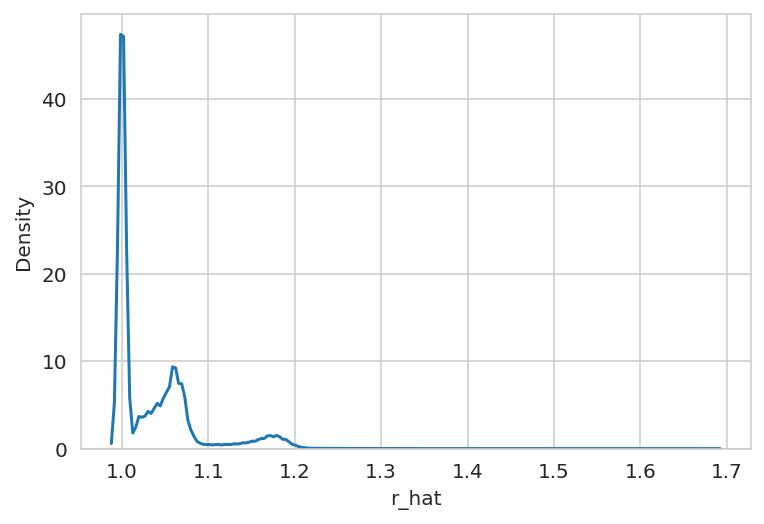

In [10]:
sns.kdeplot(x=prostate_post_summary["r_hat"]);

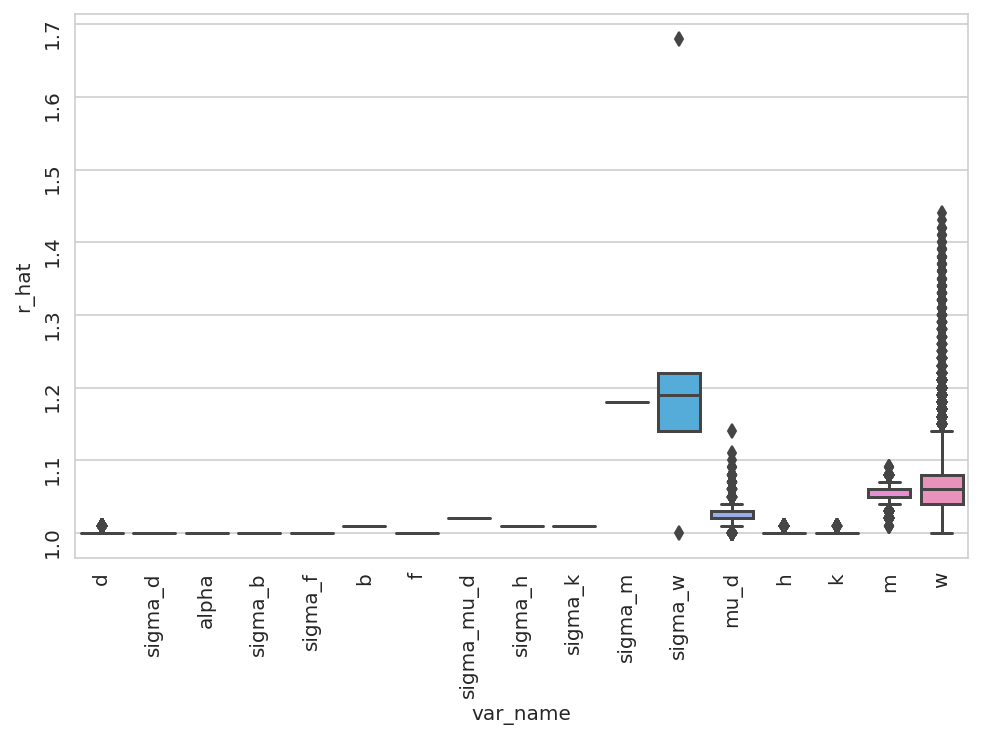

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=prostate_post_summary, x="var_name", y="r_hat", ax=ax)
ax.tick_params(rotation=90)
plt.show()

In [12]:
sgrna_to_gene_map = (
    prostate_data.copy()[["hugo_symbol", "sgrna"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

The posteriors for the varying sgRNA effect $d$ are far more variable than $\mu_d$ which basically collapsed to 0.

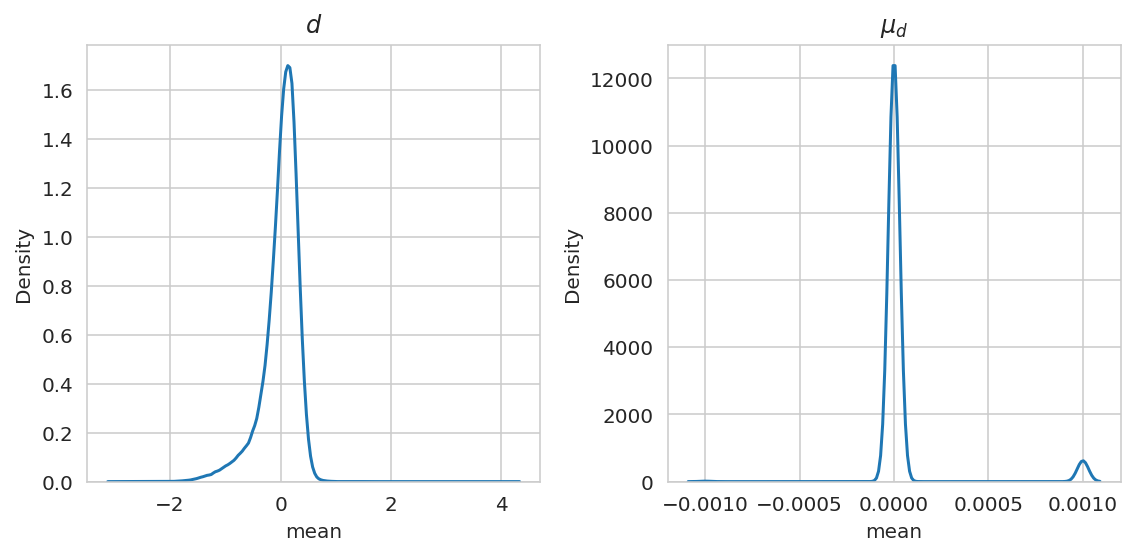

In [13]:
d_post = (
    prostate_post_summary.query("var_name == 'd'")
    .reset_index(drop=True)
    .pipe(extract_coords_param_names, names=["sgrna"], col="parameter")
    .merge(sgrna_to_gene_map, on="sgrna", how="left")
)

mu_d_post = (
    prostate_post_summary.query("var_name == 'mu_d'")
    .reset_index(drop=True)
    .pipe(extract_coords_param_names, names=["hugo_symbol"], col="parameter")
)

fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

sns.kdeplot(d_post["mean"], ax=axes[0])
axes[0].set_title(r"$d$")

sns.kdeplot(mu_d_post["mean"], ax=axes[1])
axes[1].set_title(r"$\mu_d$")

plt.tight_layout()
plt.show()

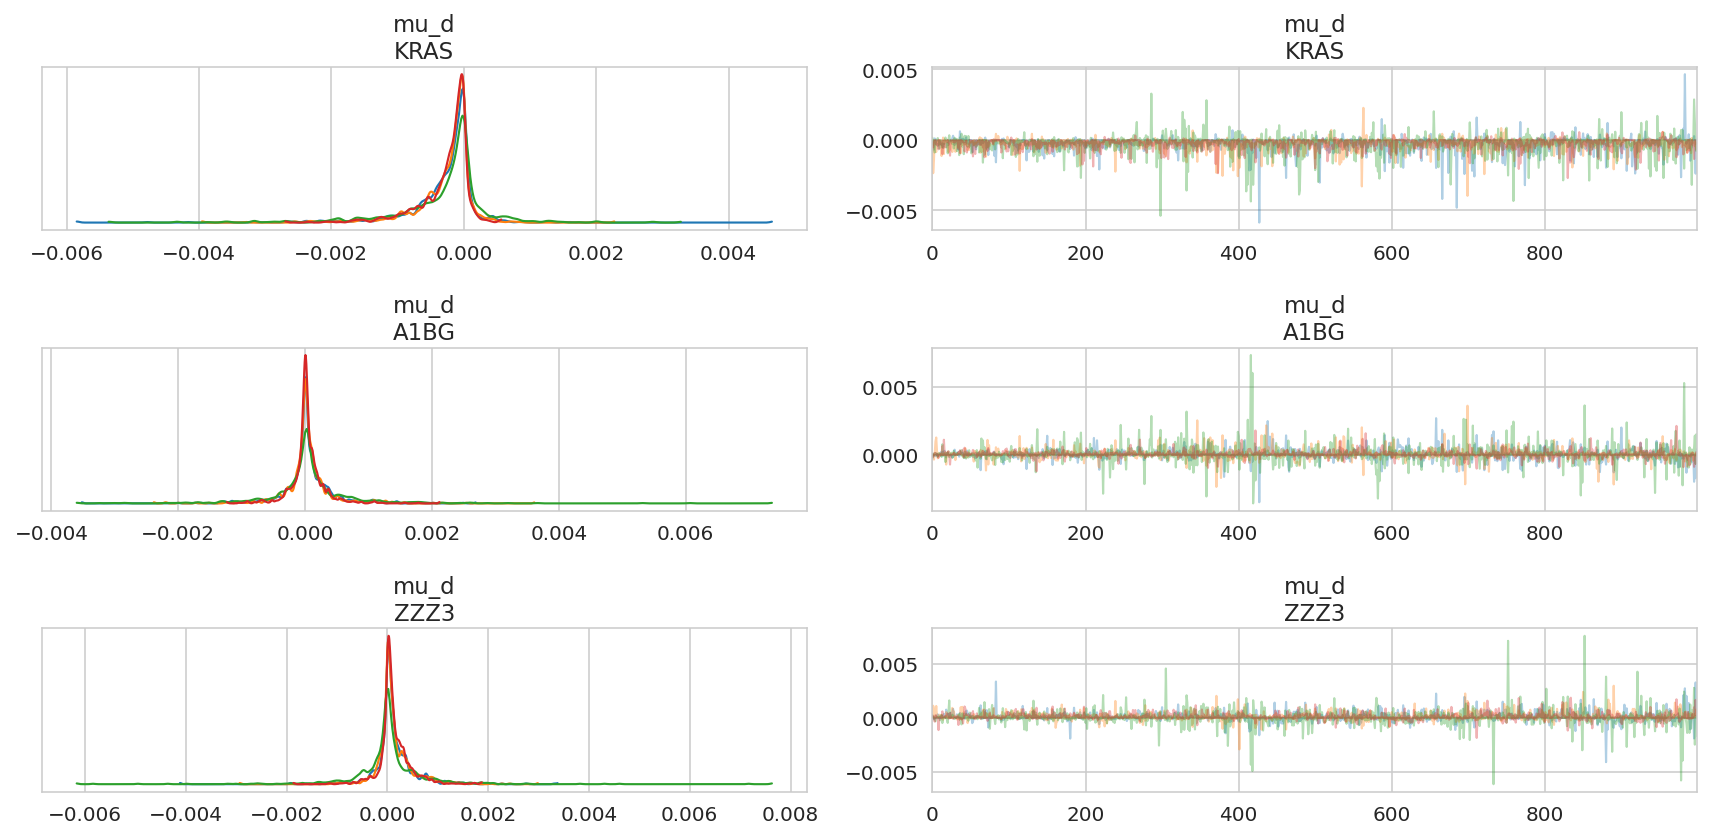

In [14]:
az.plot_trace(
    trace, var_names="mu_d", coords={"gene": ["KRAS", "A1BG", "ZZZ3"]}, compact=False
)
plt.tight_layout()
plt.show()

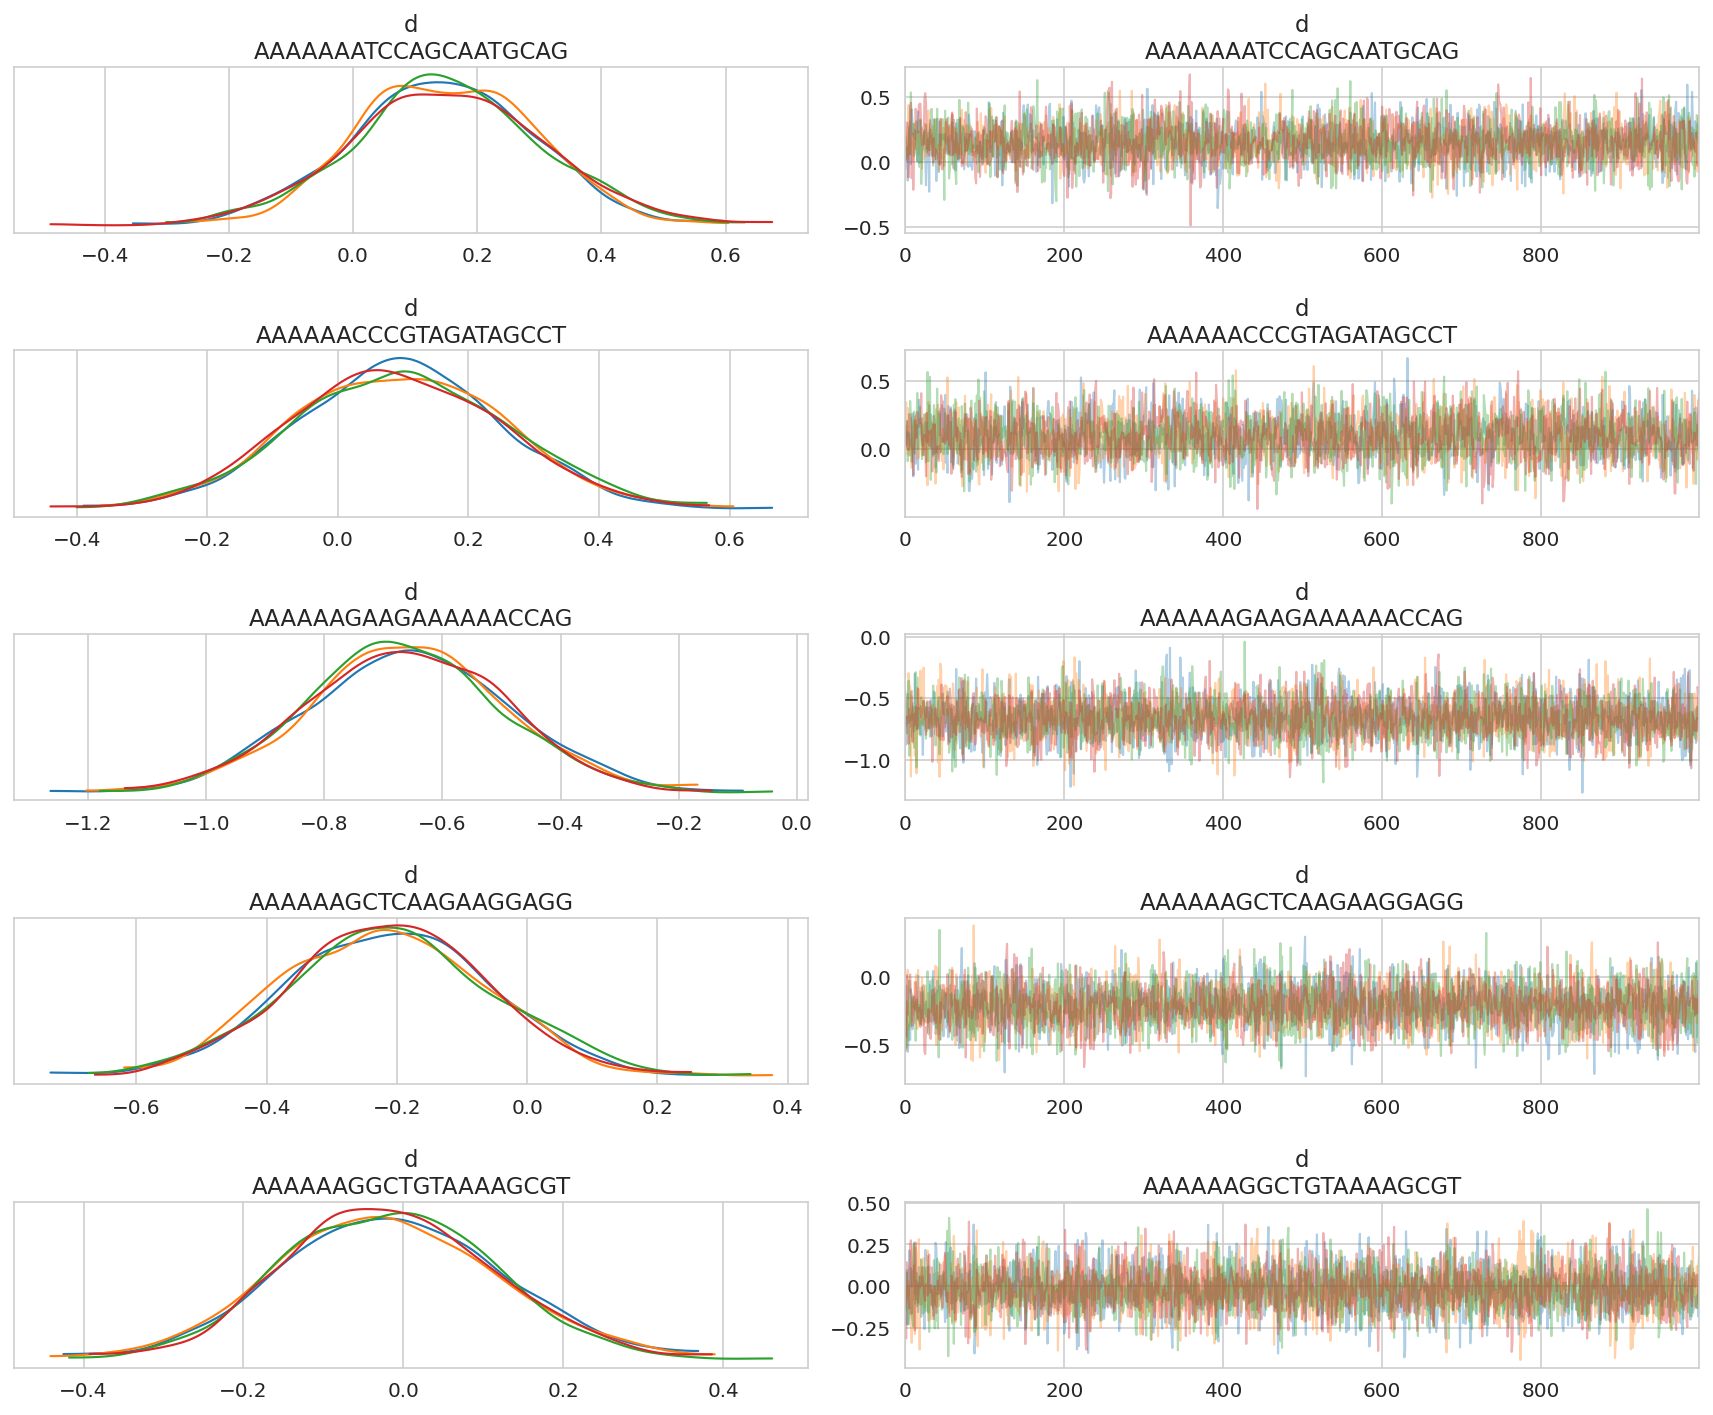

In [15]:
sgrnas_sample = trace.posterior.coords["sgrna"].values[:5]

az.plot_trace(trace, var_names="d", coords={"sgrna": sgrnas_sample}, compact=False)
plt.tight_layout()
plt.show()

The averages of the sgRNA posteriors for each gene have variability that never made it to $\mu_d$.

In [16]:
d_post.groupby("hugo_symbol")[["mean", "hdi_5.5%", "hdi_94.5%"]].mean().reset_index(
    drop=False
).head()

hugo_symbol     mean  hdi_5.5%  hdi_94.5%
0        A1BG  0.24975   0.02650    0.47075
1        A1CF  0.22550   0.01625    0.43650
2         A2M  0.00875  -0.20450    0.22325
3       A2ML1  0.32950   0.10900    0.55225
4     A3GALT2  0.14800  -0.06425    0.36500

In [17]:
mu_d_post.query("hugo_symbol == 'A1BG'")

parameter  mean   sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
0  mu_d[A1BG]   0.0  0.0    -0.001      0.001        0.0      0.0    3542.0   

   ess_tail  r_hat var_name hugo_symbol  
0    1844.0   1.03     mu_d        A1BG

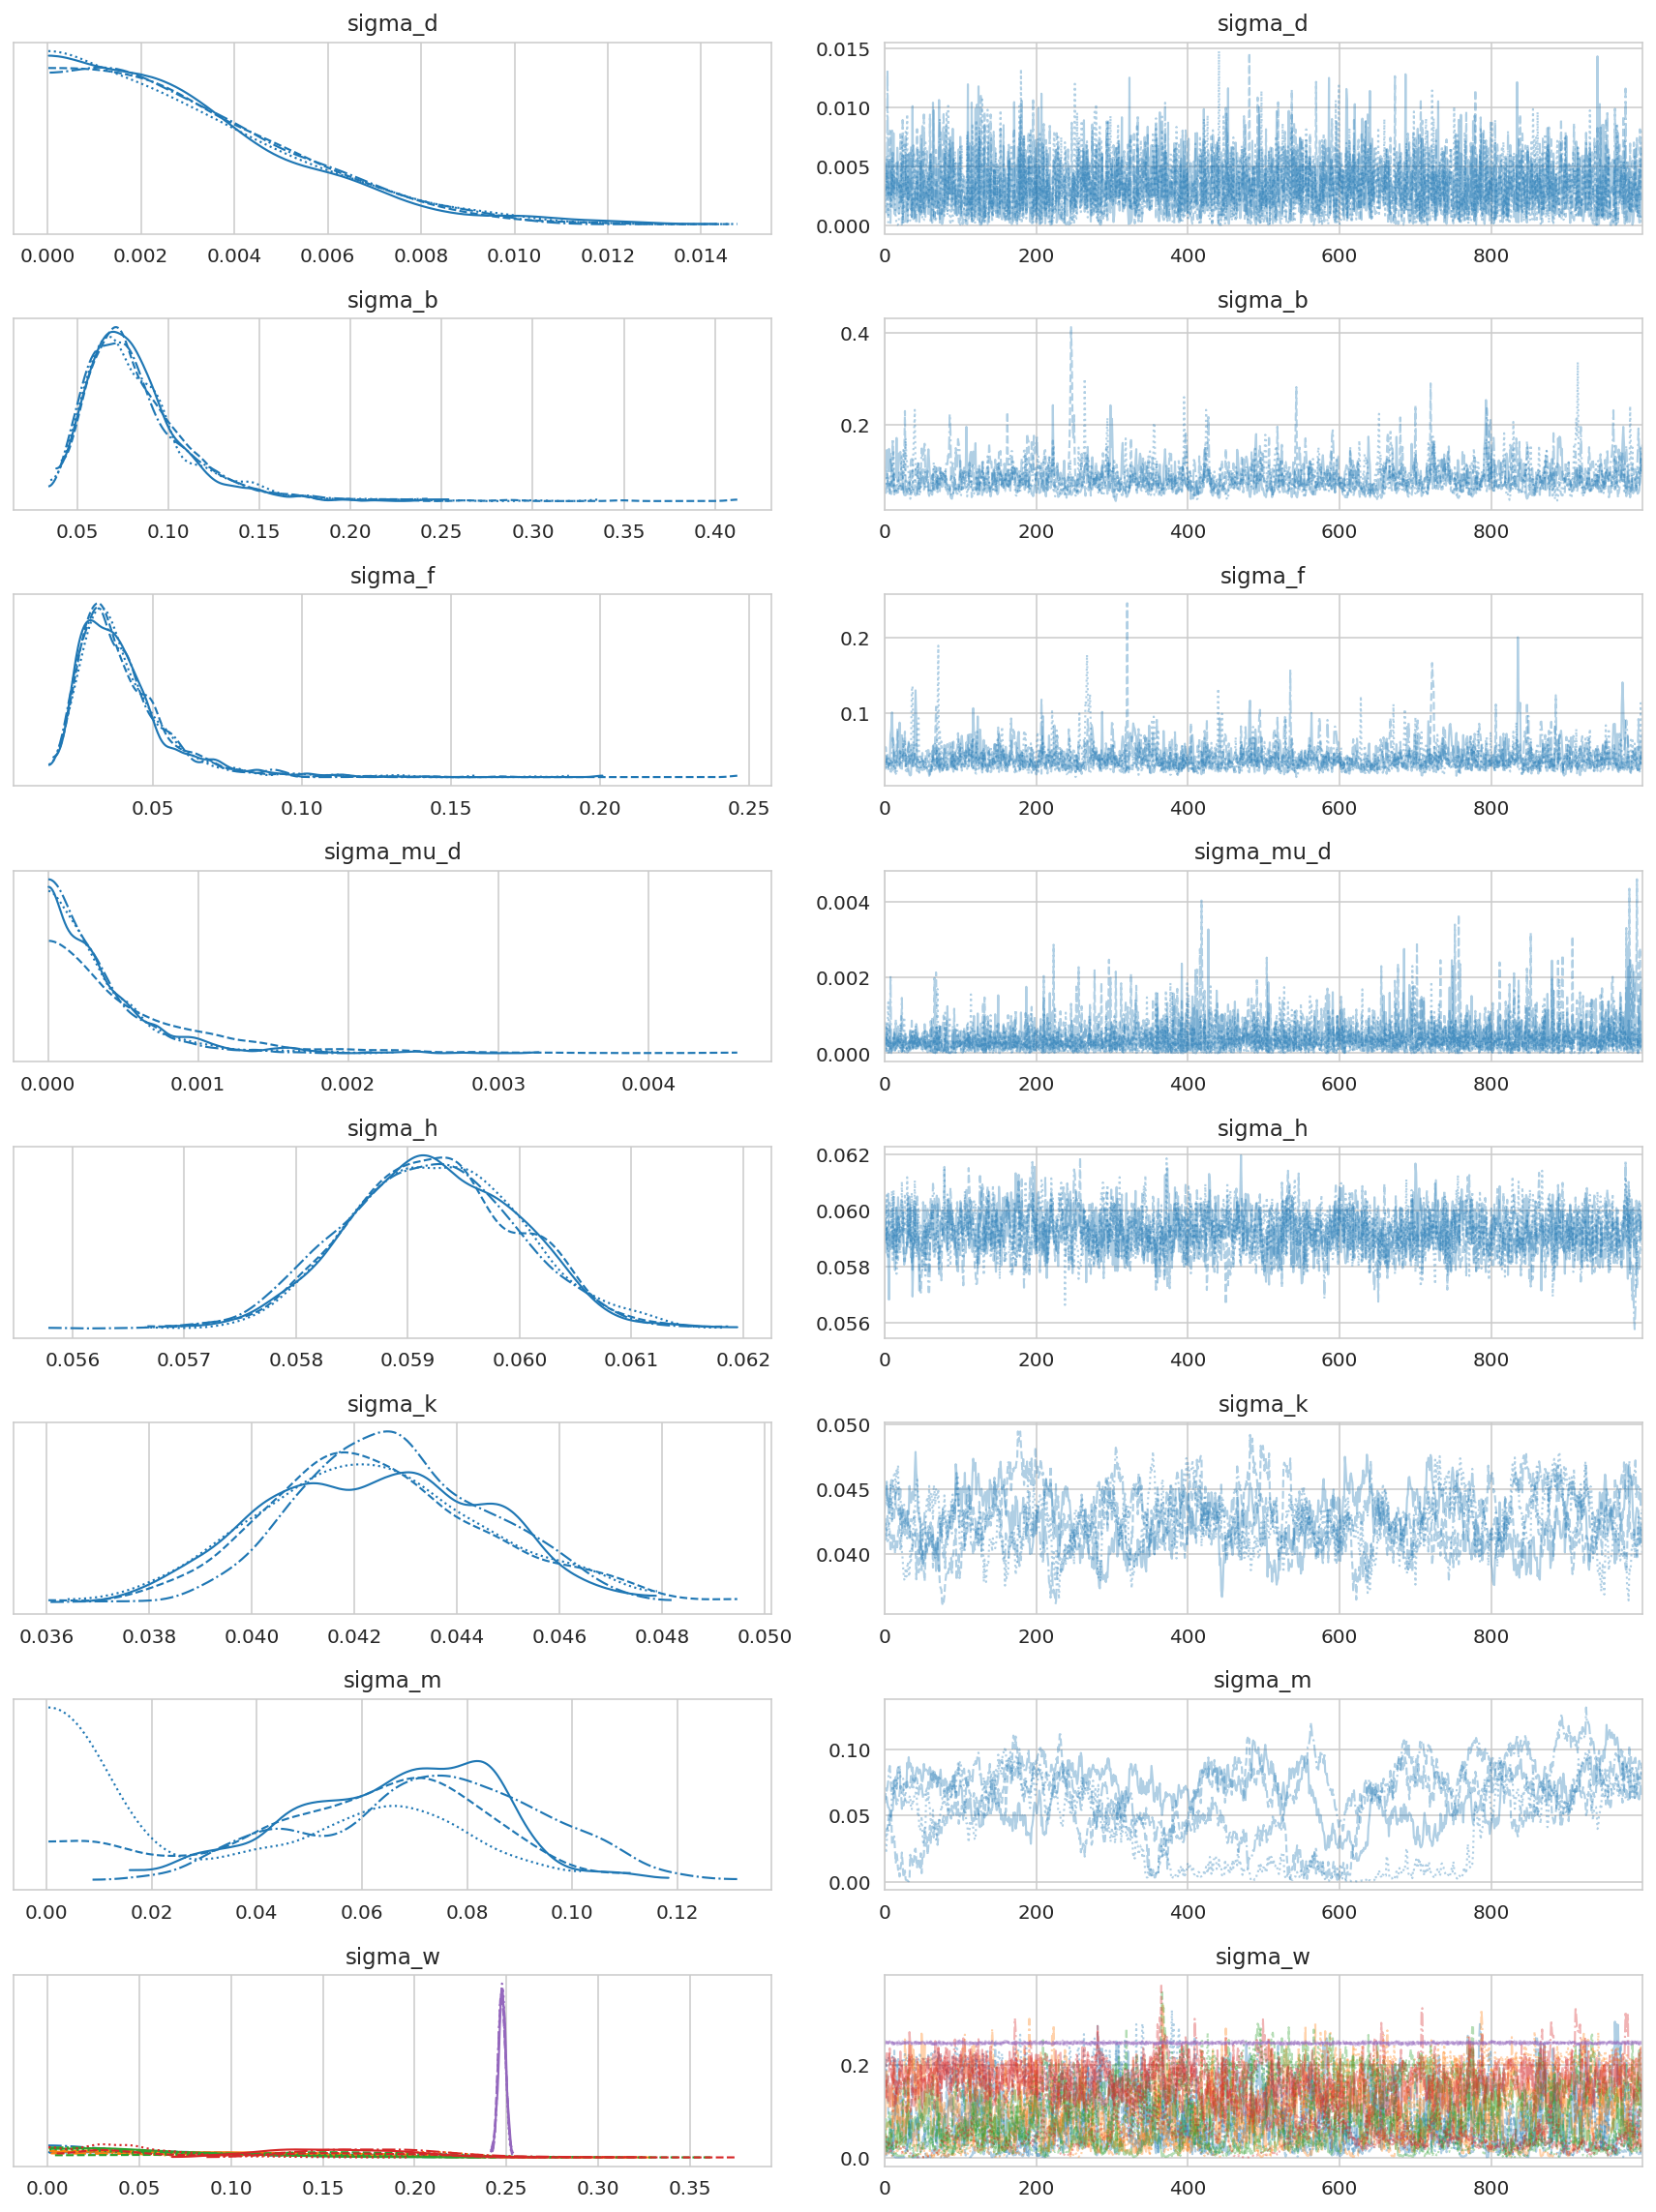

In [18]:
az.plot_trace(trace, var_names=["^sigma_*"], filter_vars="regex")
plt.tight_layout()

I wanted to briefly see if the sgRNA-to-gene indexing is incorrect, but everything seems fine.

In [19]:
valid_prostate_data = prostate_model.data_processing_pipeline(prostate_data.copy())
prostate_mdl_data = prostate_model.make_data_structure(valid_prostate_data)

[07/12/22 16:19:08] INFO     Processing data for modeling.     ]8;id=148681;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=596189;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#241\241]8;;\

In [20]:
gene = "A1BG"
gene_codes = valid_prostate_data["hugo_symbol"][
    valid_prostate_data["hugo_symbol"] == gene
].cat.codes.unique()
assert len(gene_codes) == 1
gene_code = gene_codes[0]
assert trace.posterior.coords["gene"][gene_code].values == gene

sgrna_idx = np.where(prostate_mdl_data.sgrna_to_gene_idx == gene_code)
sgrnas = trace.posterior.coords["sgrna"][sgrna_idx].values
sgrna_to_gene_map.filter_column_isin("sgrna", sgrnas)

hugo_symbol                 sgrna
44225        A1BG  GGAAGTCTGGAGTCTCCAGG
54943        A1BG  GTGGACTTCCAGCTACGGCG
55251        A1BG  GTGTGCCGAGGTGTGCTGCG
58549        A1BG  TCAATGGTCACAGTAGCGCT

In [21]:
len(prostate_mdl_data.sgrna_to_gene_idx), len(set(prostate_mdl_data.sgrna_to_gene_idx))

(71062, 18119)

The trace for $b$ is highly autocorrelated.
It's very obvious when compared to the trace of $f$.

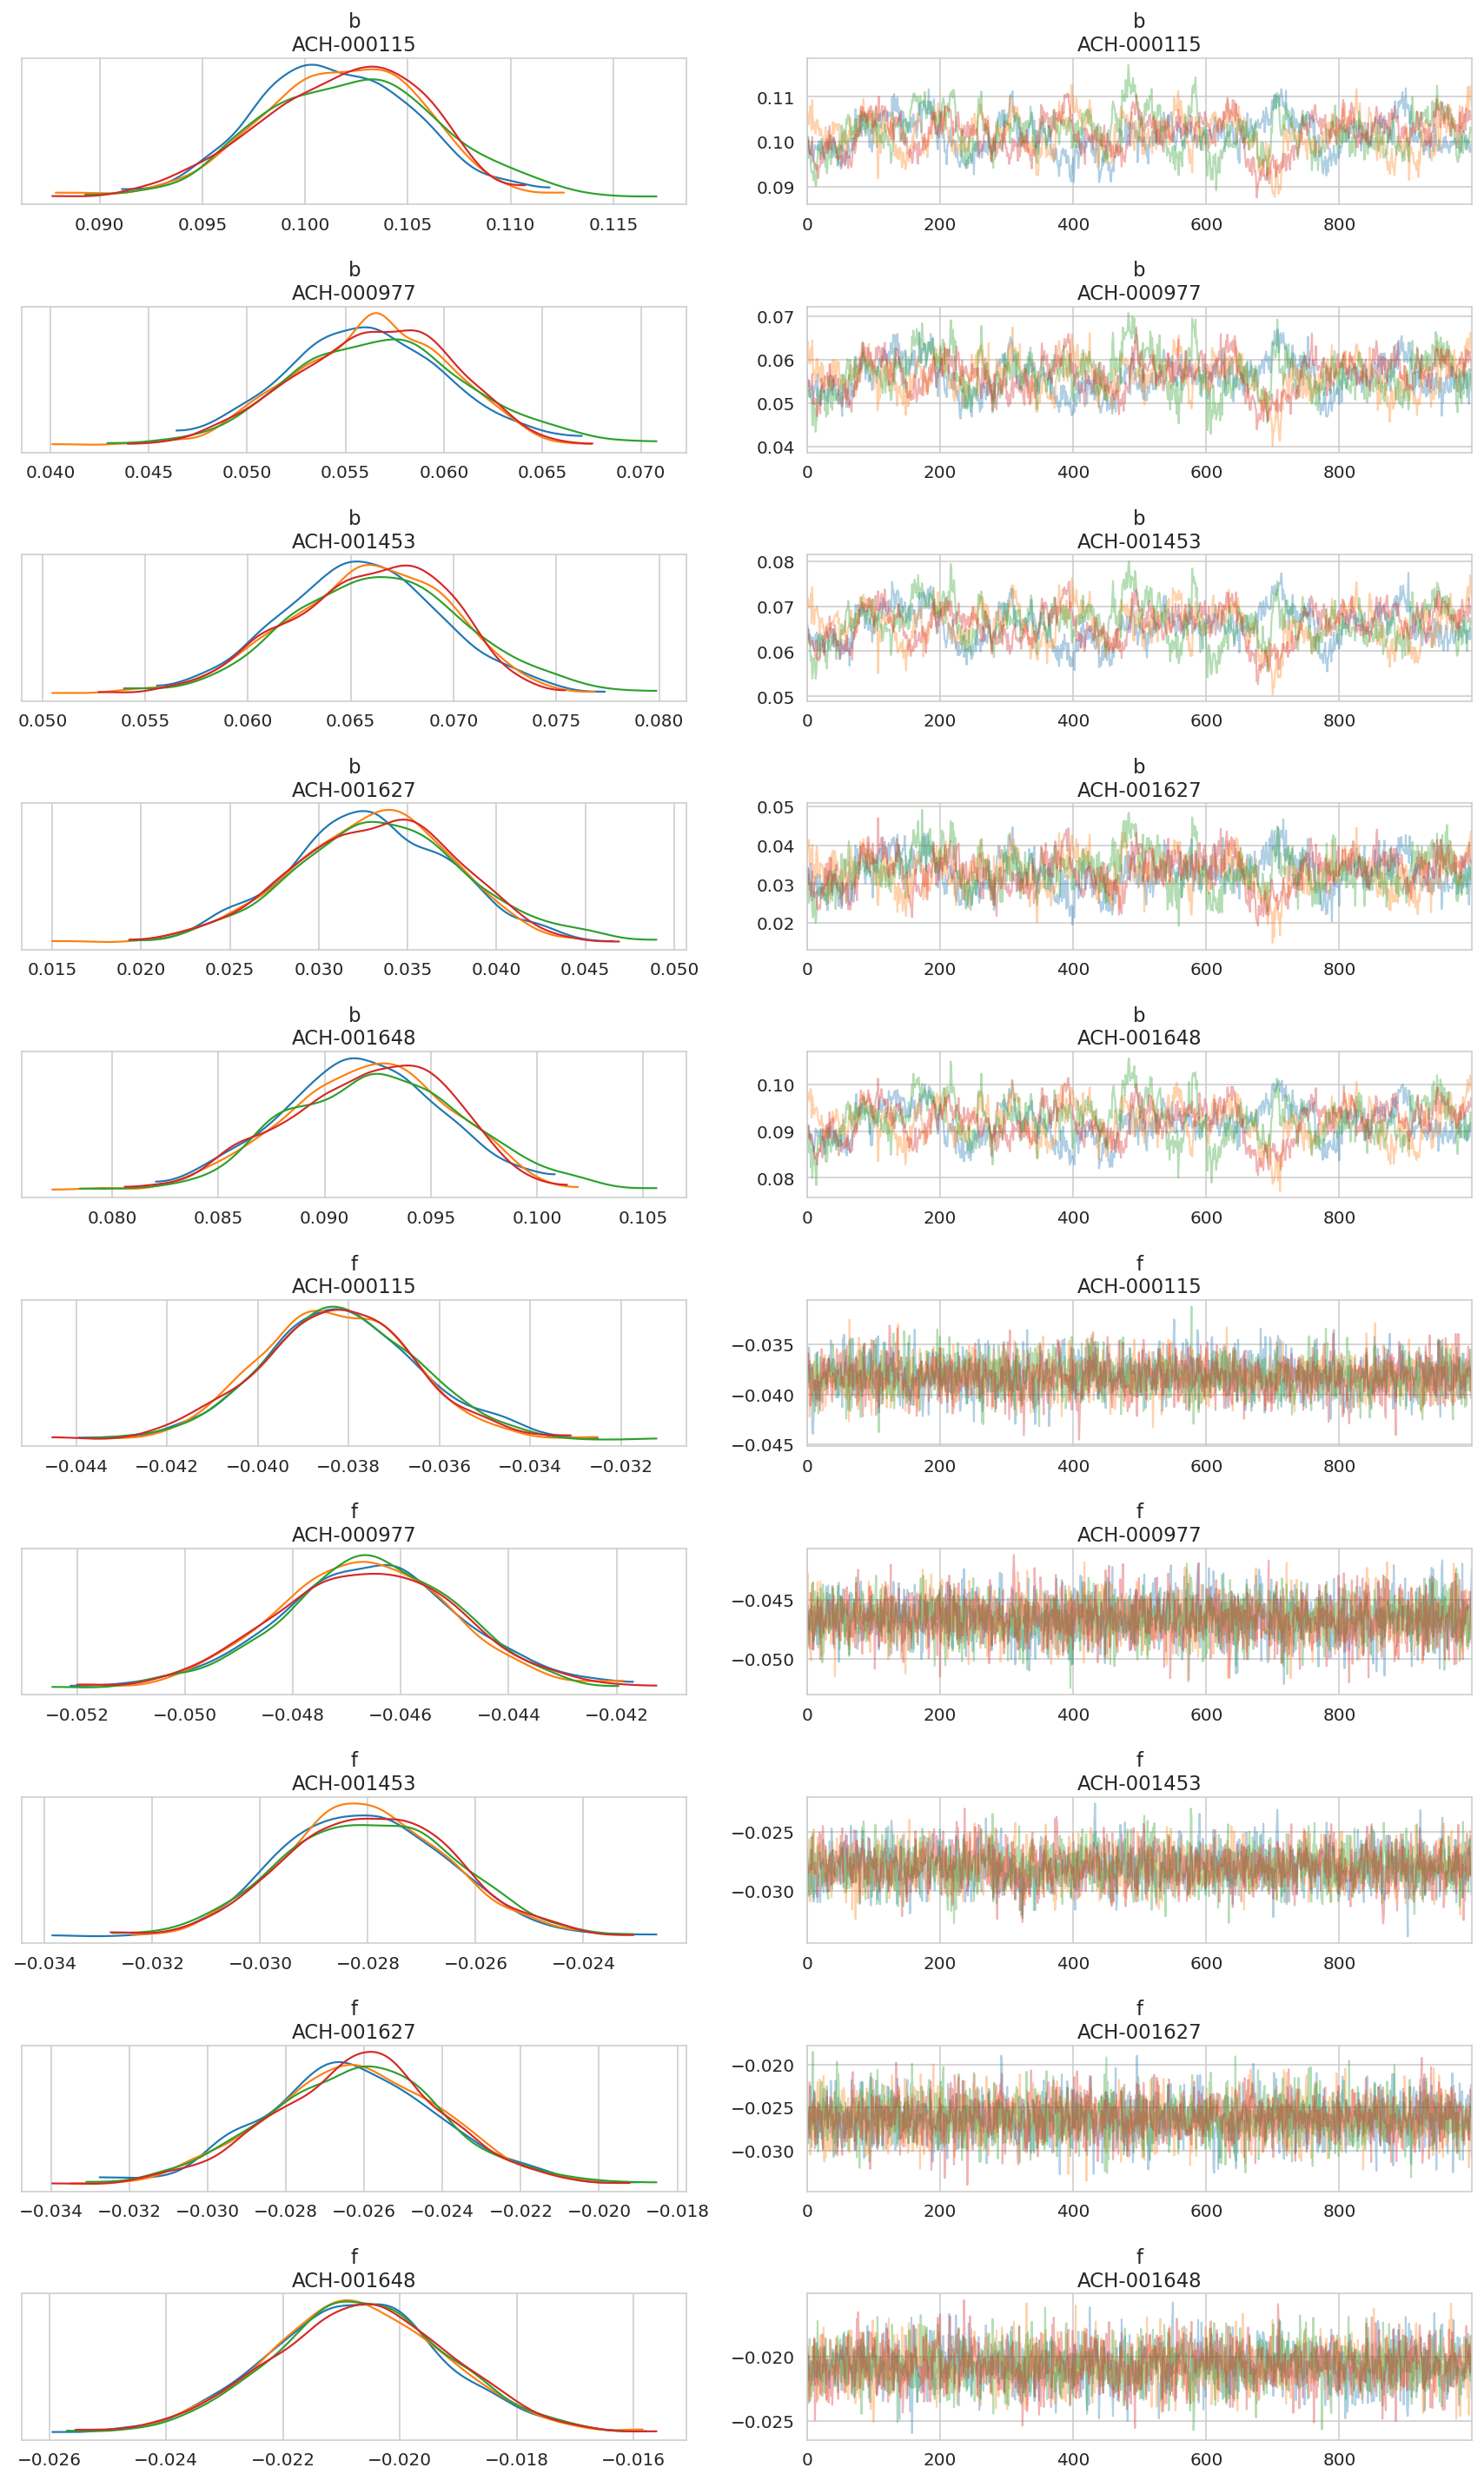

In [22]:
az.plot_trace(trace, var_names=["b", "f"], compact=False)
plt.tight_layout()
plt.show()

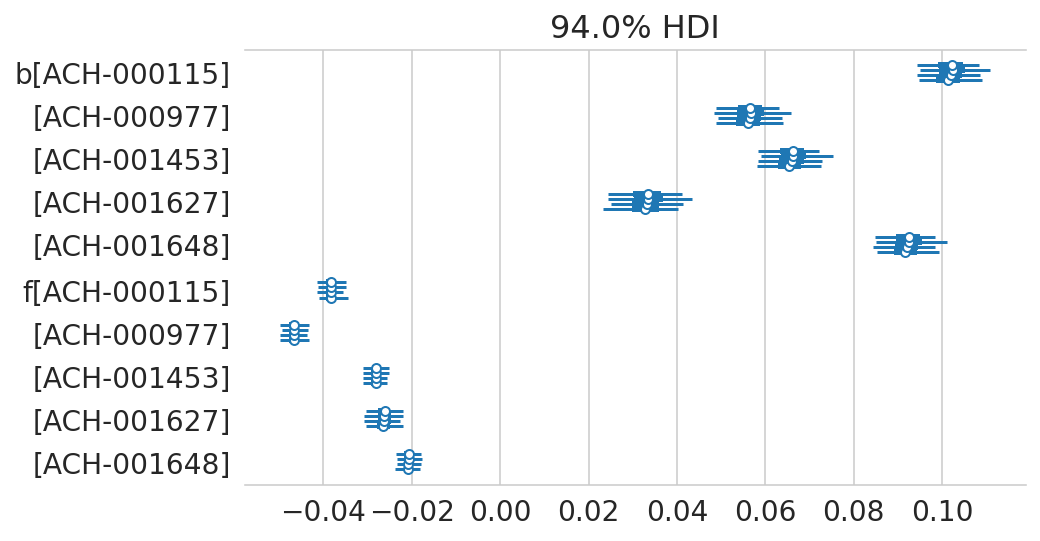

In [23]:
az.plot_forest(trace, var_names=["b", "f"], figsize=(7, 4));

A little analysis of $w$ comutation variable.
All of the $\sigma_w$ were poorly sampled except for *ZFHX3*.

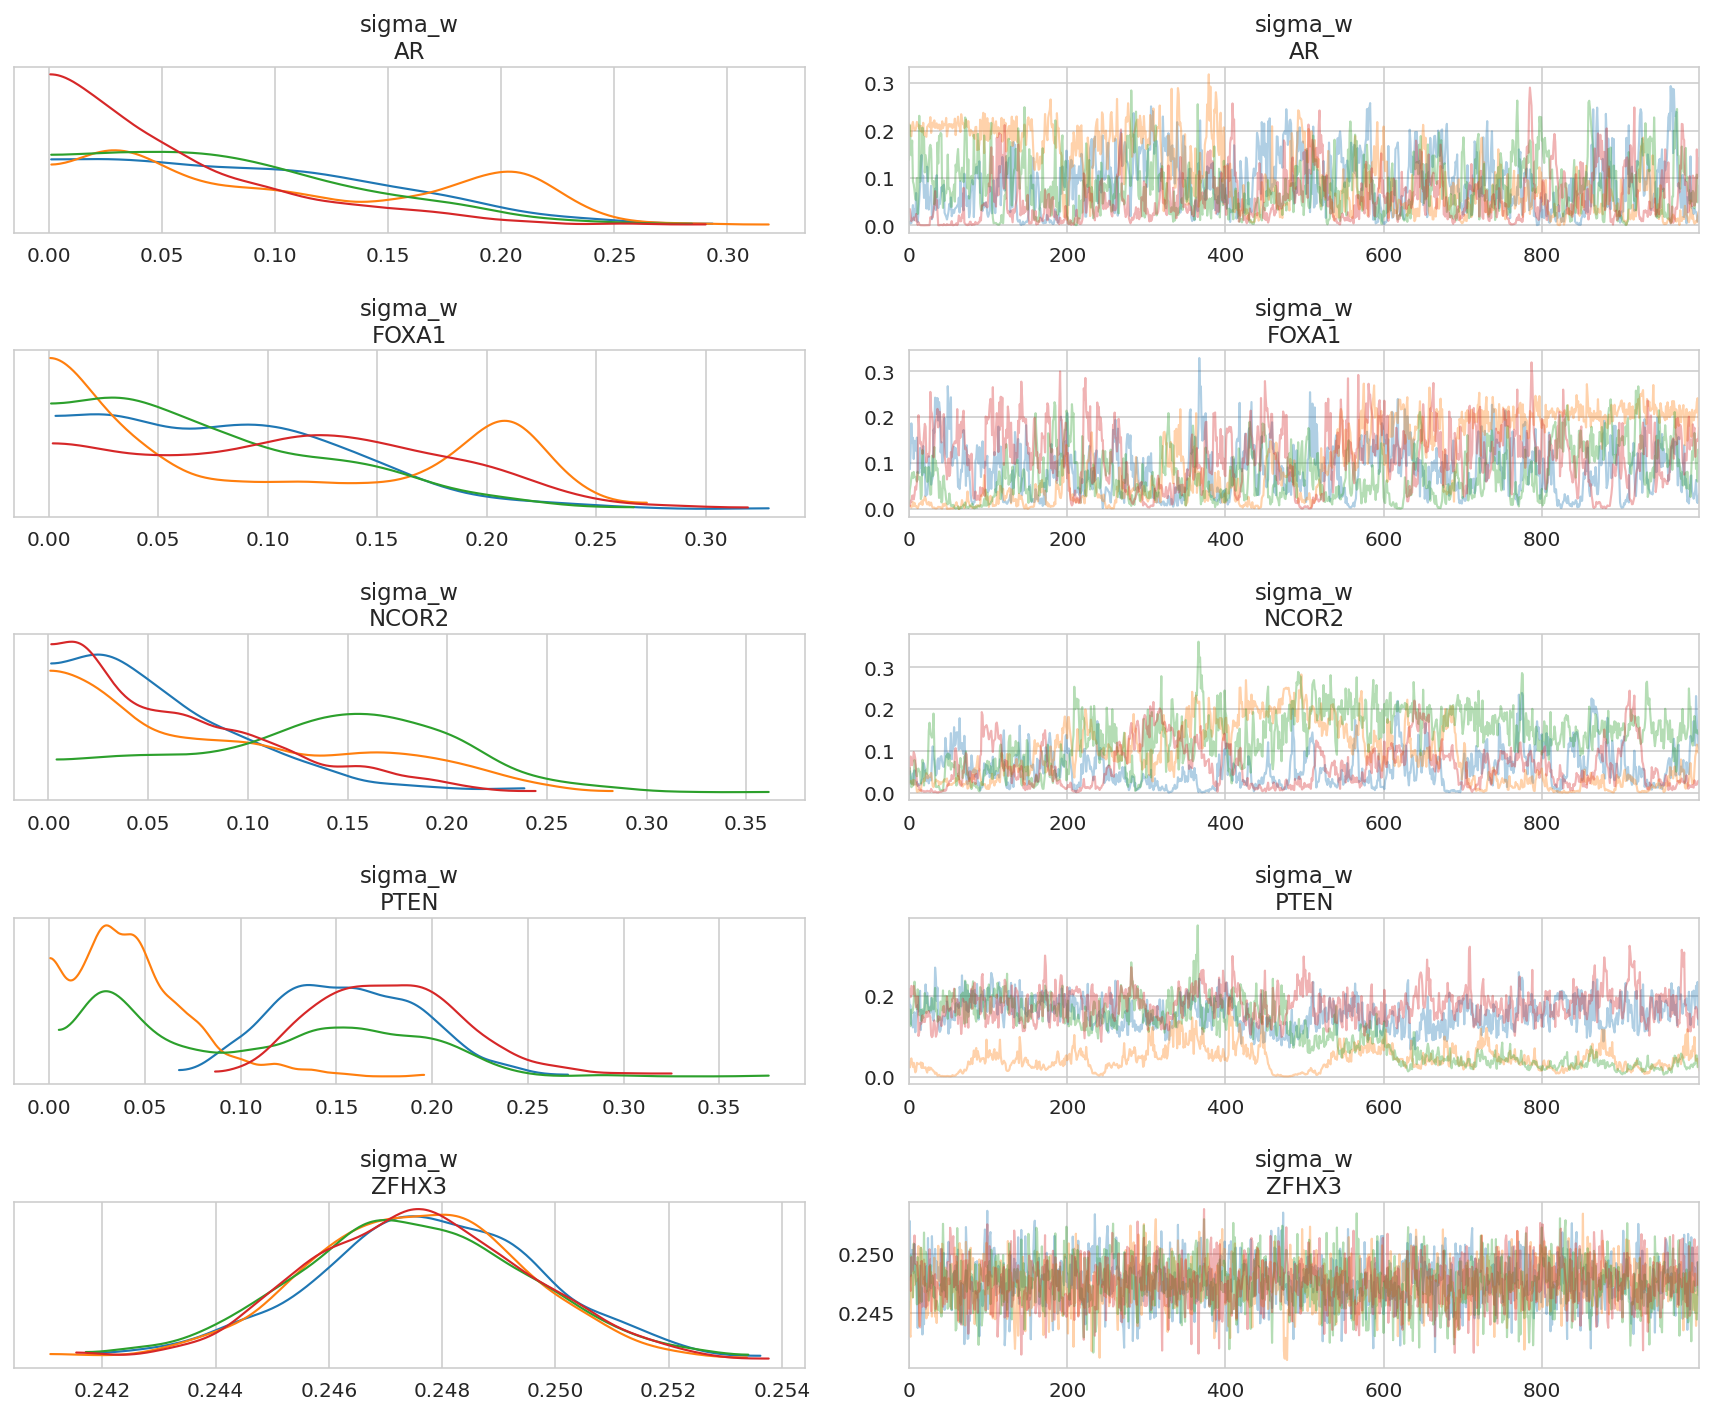

In [24]:
az.plot_trace(trace, var_names="sigma_w", compact=False)
plt.tight_layout()
plt.show()

In [25]:
cancer_genes_mutations = (
    valid_prostate_data.filter_column_isin(
        "hugo_symbol", trace.posterior.coords["cancer_gene"].values
    )[["depmap_id", "hugo_symbol", "is_mutated"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .sort_values(["depmap_id", "hugo_symbol"])
    .pivot_wider("hugo_symbol", names_from="depmap_id", values_from="is_mutated")
    .set_index("hugo_symbol")
)
cancer_genes_mutations

ACH-000115  ACH-000977  ACH-001453  ACH-001627  ACH-001648
hugo_symbol                                                            
AR                False        True       False       False       False
FOXA1             False        True       False       False       False
NCOR2             False        True       False       False       False
PTEN              False        True       False       False       False
ZFHX3             False        True       False        True       False

In [26]:
w_post_summary = (
    prostate_post_summary.query("var_name == 'w'")
    .reset_index(drop=True)
    .pipe(
        extract_coords_param_names,
        names=["target_gene", "cancer_gene"],
        col="parameter",
    )
)
w_post_summary.head()

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0     w[A1BG, AR]  0.002  0.091    -0.134      0.159      0.001    0.005   
1  w[A1BG, FOXA1]  0.007  0.100    -0.155      0.158      0.002    0.005   
2  w[A1BG, NCOR2]  0.002  0.093    -0.143      0.151      0.001    0.007   
3   w[A1BG, PTEN]  0.003  0.118    -0.193      0.191      0.002    0.013   
4  w[A1BG, ZFHX3] -0.029  0.133    -0.246      0.180      0.002    0.002   

   ess_bulk  ess_tail  r_hat var_name target_gene cancer_gene  
0    4661.0    1418.0   1.05        w        A1BG          AR  
1    4274.0     781.0   1.06        w        A1BG       FOXA1  
2    5152.0     213.0   1.06        w        A1BG       NCOR2  
3    4025.0     409.0   1.21        w        A1BG        PTEN  
4    4153.0    3495.0   1.00        w        A1BG       ZFHX3

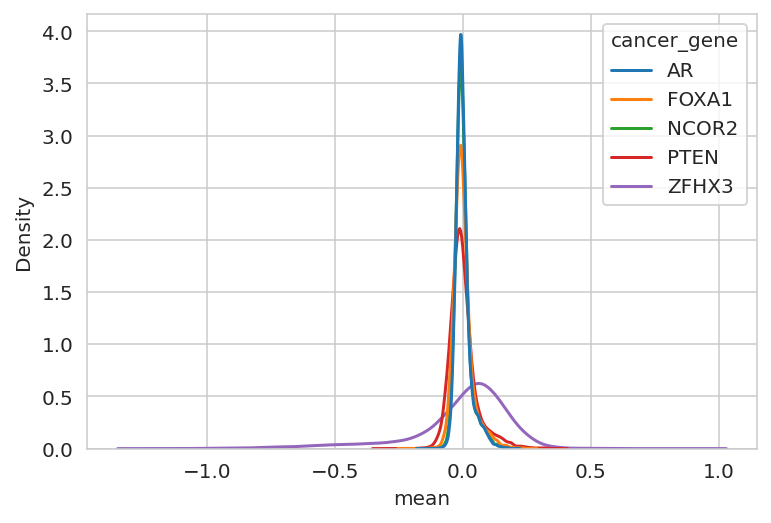

In [27]:
sns.kdeplot(data=w_post_summary, x="mean", hue="cancer_gene");

/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


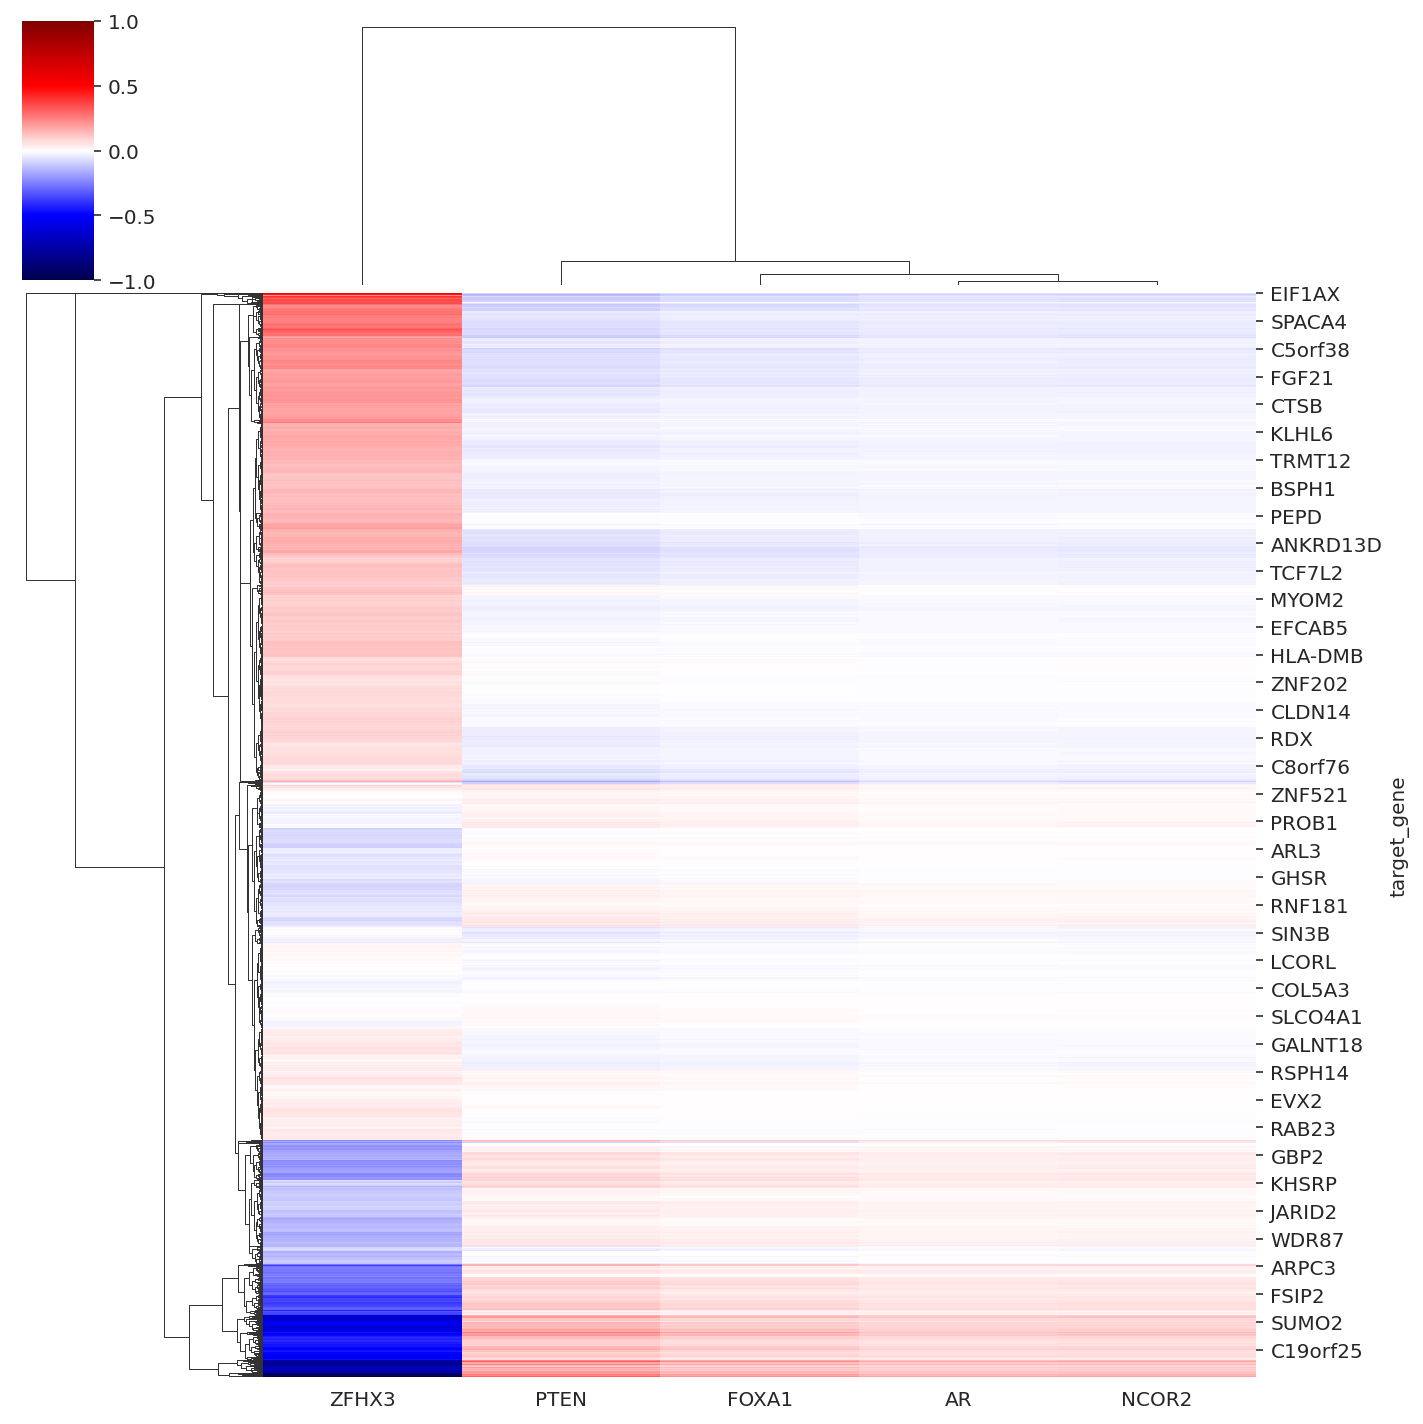

In [28]:
plt_df = w_post_summary.pivot_wider(
    "target_gene", names_from="cancer_gene", values_from="mean"
).set_index("target_gene")

sns.clustermap(plt_df, cmap="seismic", vmin=-1, vmax=1)

In [29]:
example_cancer_gene = "ZFHX3"
example_w = w_post_summary.query(f"cancer_gene == '{example_cancer_gene}'")

example_hits = (
    example_w.sort_values("mean").pipe(head_tail, n=10)["target_gene"].tolist()
)

In [30]:
cancer_gene_muts = list(
    prostate_data.query(f"hugo_symbol == '{example_cancer_gene}'")
    .query("is_mutated")["depmap_id"]
    .unique()
)

In [31]:
example_hit_data = (
    prostate_data.filter_column_isin("hugo_symbol", example_hits)
    .assign(cancer_gene_mut=lambda d: [cl in cancer_gene_muts for cl in d["depmap_id"]])
    .astype({"hugo_symbol": str})
)
example_hit_data["hugo_symbol"] = pd.Categorical(
    example_hit_data["hugo_symbol"], categories=example_hits, ordered=True
)

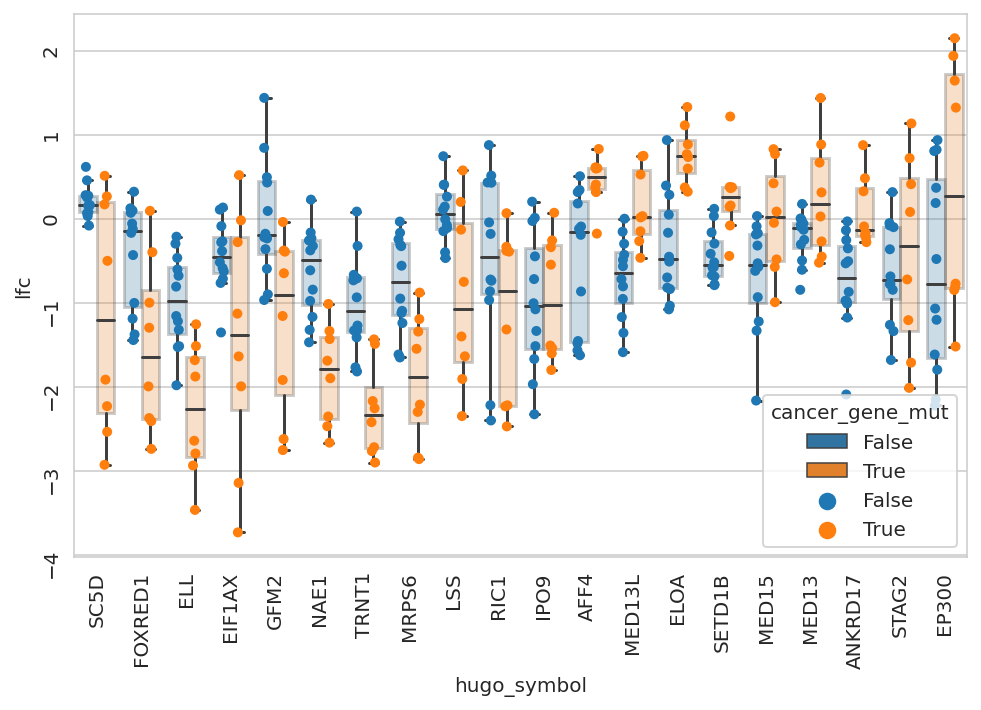

In [32]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(
    data=example_hit_data,
    x="hugo_symbol",
    y="lfc",
    hue="cancer_gene_mut",
    ax=ax,
    fliersize=0,
    boxprops={"alpha": 0.25},
)
sns.stripplot(
    data=example_hit_data,
    x="hugo_symbol",
    y="lfc",
    hue="cancer_gene_mut",
    dodge=True,
    ax=ax,
)
ax.tick_params(rotation=90)
plt.show()

Some of the other parameters (note that they share the same x-axis).

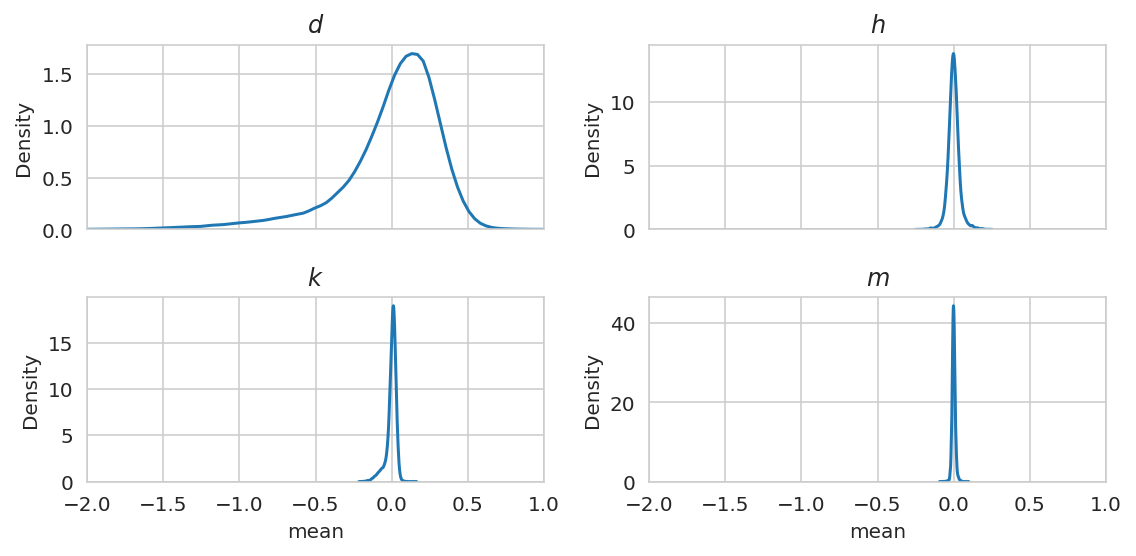

In [33]:
var_names = ["d", "h", "k", "m"]
_, axes = plt.subplots(2, 2, figsize=(8, 4), sharex=True)
for ax, var_name in zip(axes.flatten(), var_names):
    x = prostate_post_summary.query(f"var_name == '{var_name}'")["mean"]
    sns.kdeplot(x=x, ax=ax)
    ax.set_title(f"${var_name}$")
    ax.set_xlim(-2, 1)

plt.tight_layout()
plt.show()

---

## Session info

In [34]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 2.13 minutes


In [35]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-07-12

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 3.10.0-1160.45.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-17-83.o2.rc.hms.harvard.edu

Git branch: simplify

seaborn   : 0.11.2
numpy     : 1.23.0
pandas    : 1.4.3
arviz     : 0.12.1
matplotlib: 3.5.2

